# The Constant Expected Return Model

The constant expected return model assumes that an asset's return over time is independent and identically normally distributed with a constant (time invariant) mean and variance. The model has very strong assumptions, but it is still widely used in fiannce as an starting point. The famous model - capital asset price model (CAPM) - is built upon based on the constant expected return model (CEM). 

Those two models become the workhorse models after Fama(1970) proposed the "efficient market hypothesis" theory. Before diving in those models, we need to talk about what those models aim for and what kind of empirical challenges we are facing in practice.

## The Big Picture: it's all about risk and return

Predicting the distribution of returns of financial assets is a task of primary importance for identifying desirable investments, performing optimal asset allocation within a portfolio, as well as measuring and managing portfolio risk. __Optimal asset management depends on the statistical properties of returns and risks at different frequencies__. 

Generally, we could frame the optimal asset searching problem in two perspectives:

* The basis of the joint distrubtion of the returns of the relevant financial assets is normally at low frequency;
* The risks of a portfolio normally depends on the statistical properties of the distribution of returns at high frequencies. 

To investigate returns and risks, we would go throgh the following process:

* Data collection and transformation
* Graphical and descriptive data analysis
* Model specification
* Model estiamtion
* Model validation
* Model simulation
* Simulate the portofil performances based on the results of model

CER REGRESSION MODEL: for assets $i = 1, \cdots, N$ and time period $t = 1, \cdots, T$, the CER regression model is:

$$r_{it} = \mu_i + \epsilon_{it}, \ \ \ \ \epsilon_{it} \sim GWN(0, \sigma_i^2) $$
and 
$$cov(\epsilon_{it}, \epsilon_{js}) = \begin{cases}  \sigma_{ij}, &  \ \ t = s \\ 
 0, & \ \ t \neq s \end{cases} $$
 
 The return is convariance stationary. 

In [171]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# get the data
# stocks: microsoft, starbucks, walmart: msft, sbux, wmt
tickers = ['msft', 'sbux', 'wmt']
start_date = '1996-01-01'
end_date = '2020-12-31'
stocks = pdr.data.DataReader(tickers, 'yahoo', start_date, end_date)
stock_price = stocks['Adj Close']
stock_price

Symbols,msft,sbux,wmt
Date,,,
1996-01-02,3.562800,1.014340,7.708788
1996-01-03,3.448670,0.910305,7.791682
1996-01-04,3.468518,0.884296,7.874573
1996-01-05,3.428821,0.936314,7.750237
1996-01-08,3.423858,0.916808,7.750237
...,...,...,...
2020-12-24,222.238144,101.577553,142.903351
2020-12-28,224.443069,103.897675,144.616196
2020-12-29,223.634918,105.182205,143.700027


<AxesSubplot:xlabel='Date'>

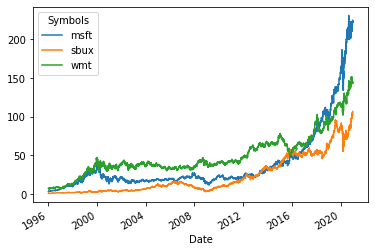

In [3]:
stock_price.plot()

In [4]:
# transform the data
stock_price_clean = stock_price.dropna().copy()  # drop na
daily_simple_return = stock_price_clean.pct_change()
daily_simple_return_clean = daily_simple_return.dropna()
daily_simple_return_clean

Symbols,msft,sbux,wmt
Date,,,
1996-01-03,-0.032034,-0.102564,0.010753
1996-01-04,0.005755,-0.028571,0.010638
1996-01-05,-0.011445,0.058823,-0.015790
1996-01-08,-0.001447,-0.020833,0.000000
1996-01-09,-0.070290,-0.028369,-0.016043
...,...,...,...
2020-12-24,0.007827,-0.000490,0.001955
2020-12-28,0.009921,0.022841,0.011986
2020-12-29,-0.003601,0.012363,-0.006335


<AxesSubplot:xlabel='Date'>

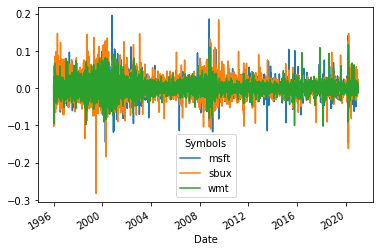

In [5]:
daily_simple_return_clean.plot()

<AxesSubplot:xlabel='Date'>

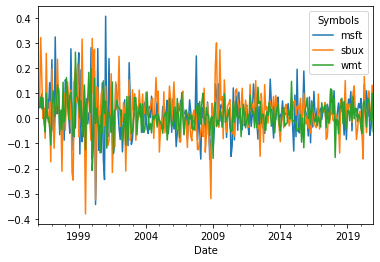

In [30]:
stock_price_monthly = stock_price.resample('M').ffill().dropna()
monthly_return = stock_price_monthly.pct_change()
monthly_return.plot()

In [6]:
# calculate the mean
daily_mean = daily_simple_return_clean.mean()
daily_mean

Symbols
msft    0.000855
sbux    0.001023
wmt     0.000597
dtype: float64

In [7]:
# transform the mean
daily_mean_list = list(daily_mean) * (daily_simple_return.shape[0] - 1)
daily_mean_mat = np.array(daily_mean_list).reshape((-1, 3))
daily_mean_mat

array([[0.00085462, 0.00102336, 0.00059658],
       [0.00085462, 0.00102336, 0.00059658],
       [0.00085462, 0.00102336, 0.00059658],
       ...,
       [0.00085462, 0.00102336, 0.00059658],
       [0.00085462, 0.00102336, 0.00059658],
       [0.00085462, 0.00102336, 0.00059658]])

In [8]:
daily_noise = np.subtract(daily_simple_return_clean, daily_mean_mat)

<AxesSubplot:xlabel='Date'>

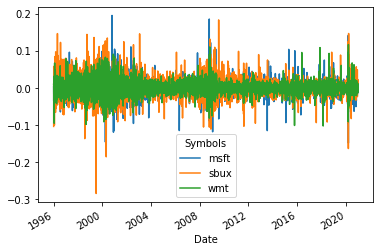

In [9]:
daily_noise.plot()  # since mean of daily return is zero

### Vector Autoregression 

In the constant expected return, we assume that $E[\epsilon_{it]] 0 $ means that news, on average, is neutral; neither good nor bad. The assumption that $var(\epsilon_{it}) = \sigma_i^2$ can be interpreted as sayting that volatility, or typical magnitude, of news arrival is constant over time. The random news variable affecting asset $i, \epsilon_{it}$, is allowed to be contemporaneously correlated with the random news variable affecting asset may spill over and affect another asset. 

Sometimes it is convinent to re-express the CER model as 

$$r_{it} = \mu_i + \epsilon_{it} = \mu_i + \sigma_i \cdot z_{it}; \ \ \ \{z_{it}\}_{t=1}^T \sim GWN(0, 1) $$

In this form, the random news shock is the _iid_ standard. To model the autocorrelation between different assets, we need to use vector autoregression mode as we assume:

$$cov(\epsilon_{it}, \epsilon_{js}) = \sigma_{ij}, \ t = s $$

In [17]:
daily_simple_return_clean.isna().any()

Symbols
msft    False
sbux    False
wmt     False
dtype: bool

In [19]:
return_var = VAR(daily_simple_return_clean)
return_results = return_var.fit(0)
return_results.summary()

/Users/Michael/.virtualenvs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Mar, 2021
Time:                     16:21:43
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.8743
Nobs:                     6294.00    HQIC:                  -23.8764
Log likelihood:           48353.0    FPE:                4.26722e-11
AIC:                     -23.8775    Det(Omega_mle):     4.26519e-11
--------------------------------------------------------------------
Results for equation msft
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000855         0.000251            3.405           0.001

Results for equation sbux
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------

We can see tha correlation between `msft` and `sbux` is 0.383779.

In [34]:
monthly_return = monthly_return.dropna()

In [35]:
# monthly return
monthly_var = VAR(monthly_return)
monthly_results = monthly_var.fit(0)
monthly_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Mar, 2021
Time:                     16:49:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.2218
Nobs:                     299.000    HQIC:                  -15.2440
Log likelihood:           1011.42    FPE:                2.36124e-07
AIC:                     -15.2589    Det(Omega_mle):     2.33771e-07
--------------------------------------------------------------------
Results for equation msft
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.017664         0.005149            3.430           0.001

Results for equation sbux
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------

### Capital Asset Price Model (CAPM)

Sharpe(1964) and Lintner (1965) developed the CAPM for a market in which investors have the same expectations, hold portfolios of risky assts that are mean-variance efficient, and can borrow and lend money freely at the same risk-free rate. In such a market, the expected return of asset $j$ is

\begin{align}
E[R_j] & = R_{r} + \beta_j (E[R_m] - R_r)  \\
\beta_j & = \frac{Cov(R_j, R_m)}{Var(R_m)}
\end{align}

We will use the S&P500 Index as the proxy for the market return and the 3-month Treasury constant maturity rate as the risk-free rate.

In [40]:
# download the time series
# bank of America: BAC
# GE
# XOM, Exxon Mobile
# SP500
# 3 month treasure yield, 1, 5, 10 years yield, seasoned AAA bond, 
# crude oil prices
tickers = ['BAC', 'GE', 'XOM', 'msft', 'sbux', 'wmt', '^gspc']
start_date = '2000-01-02'
end_date = '2013-05-31'
stocks = pdr.data.DataReader(tickers, 'yahoo', start_date, end_date)

In [42]:
stocks.head()

Attributes  Adj Close                                                        \
Symbols           BAC         GE        XOM       msft      sbux        wmt   
Date                                                                          
2000-01-03  13.952057  26.585829  20.760025  37.017384  2.565109  45.439945   
2000-01-04  13.123939  25.522396  20.362385  35.766914  2.483831  43.739662   
2000-01-05  13.267960  25.478096  21.472454  36.144032  2.516343  42.847008   
2000-01-06  14.402134  25.818716  22.582546  34.933285  2.607374  43.314613   
2000-01-07  14.024072  26.818453  22.516262  35.389793  2.594370  46.587620   

Attributes                  Close                       ...      Open          \
Symbols           ^gspc       BAC         GE       XOM  ...      sbux     wmt   
Date                                                    ...                     
2000-01-03  1455.219971  24.21875  48.076923  39.15625  ...  2.984375  68.375   
2000-01-04  1399.420044  22.78125  46.153847  38.40625  ...  3.007813  65.500   
2000-01-05  1402.109985  23.03125  46.073719  40.50000  ...  2.992188  63.875   
2000-01-06  1403.449951  25.00000  46.689705  42.59375  ...  3.000000  63.000   
2000-01-07  1441.469971  24.34375  48.497597  42.46875  ...  3.093750  64.500   

Attributes                   Volume                                      \
Symbols           ^gspc         BAC          GE         XOM        msft   
Date                                                                      
2000-01-03  1469.250000  13705800.0  22952592.0  13458200.0  53228400.0   
2000-01-04  1455.219971  27293400.0  23006256.0  14510800.0  54119000.0   
2000-01-05  1399.420044  22855600.0  28384512.0  17485000.0  64059600.0   
2000-01-06  1402.109985  17307000.0  20668128.0  19461600.0  54976600.0   
2000-01-07  1403.449951  11632800.0  20947056.0  16603800.0  62013600.0   

Attributes                                       
Symbols           sbux        wmt         ^gspc  
Date                                             
2000-01-03  24232000.0  8369900.0  9.318000e+08  
2000-01-04  21564800.0  6745100.0  1.009000e+09  
2000-01-05  28206400.0  7018700.0  1.085500e+09  
2000-01-06  30825600.0  6544500.0  1.092300e+09  
2000-01-07  26044800.0  7976900.0  1.225200e+09  

[5 rows x 42 columns]

In [52]:
stock_price = stocks['Adj Close']
stock_price.columns = ['bac', 'ge', 'xom', 'msft', 'sbux', 'wmt', 'sp500']
stock_price.head()

,bac,ge,xom,msft,sbux,wmt,sp500
Date,,,,,,,
2000-01-03,13.952057,26.585829,20.760025,37.017384,2.565109,45.439945,1455.219971
2000-01-04,13.123939,25.522396,20.362385,35.766914,2.483831,43.739662,1399.420044
2000-01-05,13.267960,25.478096,21.472454,36.144032,2.516343,42.847008,1402.109985
2000-01-06,14.402134,25.818716,22.582546,34.933285,2.607374,43.314613,1403.449951
2000-01-07,14.024072,26.818453,22.516262,35.389793,2.594370,46.587620,1441.469971


In [64]:
stock_price_clean = stock_price.dropna().copy()

In [48]:
treasuries = ['DGS3MO', 'DGS1', 'DGS5', 'DGS10', 'DAAA', 'DBAA', 'DCOILWTICO']
treasury_yield = pdr.fred.FredReader(treasuries, start_date, end_date).read()


In [53]:
treasury_yield.head()
treasury_yield.columns = ['3m', '1y', '5y', '10y', 'bonda', 'bondb', 'oil']
treasury_yield.head()

,3m,1y,5y,10y,bonda,bondb,oil
DATE,,,,,,,
2000-01-03,5.48,6.09,6.50,6.58,7.75,8.27,NaN
2000-01-04,5.43,6.00,6.40,6.49,7.69,8.21,25.56
2000-01-05,5.44,6.05,6.51,6.62,7.78,8.29,24.65
2000-01-06,5.41,6.03,6.46,6.57,7.72,8.24,24.79
2000-01-07,5.38,6.00,6.42,6.52,7.69,8.22,24.79


In [63]:
yield_clean = treasury_yield.dropna().copy()

In [66]:
# combine two dataset
stock_price_clean.shape == yield_clean.shape

False

In [67]:
stock_price_clean.shape

(3373, 7)

In [68]:
yield_clean.shape

(3339, 7)

In [71]:
time_series_dataset = pd.concat([stock_price_clean, yield_clean], axis=1, join='inner')


In [73]:
time_series_dataset.isna().any()

bac      False
ge       False
xom      False
msft     False
sbux     False
wmt      False
sp500    False
3m       False
1y       False
5y       False
10y      False
bonda    False
bondb    False
oil      False
dtype: bool

In [74]:
time_series_dataset.shape

(3335, 14)

In [75]:
time_series_dataset.head()

,bac,ge,xom,msft,sbux,wmt,sp500,3m,1y,5y,10y,bonda,bondb,oil
2000-01-04,13.123939,25.522396,20.362385,35.766914,2.483831,43.739662,1399.420044,5.43,6.00,6.40,6.49,7.69,8.21,25.56
2000-01-05,13.267960,25.478096,21.472454,36.144032,2.516343,42.847008,1402.109985,5.44,6.05,6.51,6.62,7.78,8.29,24.65
2000-01-06,14.402134,25.818716,22.582546,34.933285,2.607374,43.314613,1403.449951,5.41,6.03,6.46,6.57,7.72,8.24,24.79
2000-01-07,14.024072,26.818453,22.516262,35.389793,2.594370,46.587620,1441.469971,5.38,6.00,6.42,6.52,7.69,8.22,24.79
2000-01-10,13.537992,26.807365,22.201468,35.647823,2.704906,45.737503,1457.599976,5.42,6.07,6.49,6.57,7.72,8.27,24.71


In [76]:
time_series_dataset.tail()

,bac,ge,xom,msft,sbux,wmt,sp500,3m,1y,5y,10y,bonda,bondb,oil
2013-05-24,11.686393,18.633984,65.902351,29.136339,27.728447,64.419815,1649.599976,0.04,0.12,0.90,2.01,3.94,4.76,93.84
2013-05-28,11.783485,18.689419,66.514366,29.773989,28.122316,64.428154,1660.060059,0.05,0.13,1.02,2.15,4.06,4.88,94.65
2013-05-29,11.898230,18.721088,66.298370,29.654953,27.846603,63.519901,1648.359985,0.05,0.14,1.02,2.13,4.04,4.88,93.13
2013-05-30,12.207162,18.689419,66.305550,29.782488,27.776585,63.019913,1654.410034,0.04,0.13,1.01,2.13,4.06,4.90,93.57
2013-05-31,12.057107,18.467676,65.139130,29.671965,27.632162,62.361656,1630.739990,0.04,0.14,1.05,2.16,4.09,4.95,91.93


<AxesSubplot:>

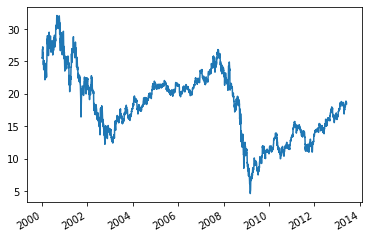

In [77]:
time_series_dataset['ge'].plot()

<AxesSubplot:>

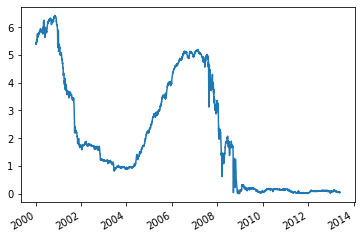

In [78]:
time_series_dataset['3m'].plot()

In [80]:
# compuate daily log return of GE stock
ge_daily_cr = np.log(time_series_dataset['ge']).diff()
ge_daily_cr.head()

2000-01-04         NaN
2000-01-05   -0.001737
2000-01-06    0.013281
2000-01-07    0.037991
2000-01-10   -0.000414
Name: ge, dtype: float64

In [82]:
sp500_daily_cr = np.log(time_series_dataset['sp500']).diff()
sp500_daily_cr.head()

2000-01-04         NaN
2000-01-05    0.001920
2000-01-06    0.000955
2000-01-07    0.026730
2000-01-10    0.011128
Name: sp500, dtype: float64

In [199]:
oil_daily_cr = np.log(time_series_dataset['oil']).diff()
oil_daily_cr.head()

2000-01-04         NaN
2000-01-05   -0.036252
2000-01-06    0.005663
2000-01-07    0.000000
2000-01-10   -0.003232
Name: oil, dtype: float64

In [117]:
# compute daily return of the risk-free asset
# accounting for the number of days between successive closing days
successive_days = time_series_dataset.index.to_series().diff().dropna().astype(int)/86400000000000

In [123]:
successive_days

2000-01-05    1.0
2000-01-06    1.0
2000-01-07    1.0
2000-01-10    3.0
2000-01-11    1.0
             ... 
2013-05-24    1.0
2013-05-28    4.0
2013-05-29    1.0
2013-05-30    1.0
2013-05-31    1.0
Length: 3334, dtype: float64

In [124]:
successive_days.shape

(3334,)

In [116]:
successive_days = successive_days.values

In [119]:
time_series_dataset['3m'].shape

(3335,)

In [122]:
time_series_dataset['3m'][1:]

2000-01-05    5.44
2000-01-06    5.41
2000-01-07    5.38
2000-01-10    5.42
2000-01-11    5.43
              ... 
2013-05-24    0.04
2013-05-28    0.05
2013-05-29    0.05
2013-05-30    0.04
2013-05-31    0.04
Name: 3m, Length: 3334, dtype: float64

In [127]:
# apply annual interest rate using 360 days/ year
daily_riskfree = np.log(1 + 0.01*time_series_dataset['3m'][1:] * successive_days/360 )
daily_riskfree

2000-01-05    0.000151
2000-01-06    0.000150
2000-01-07    0.000149
2000-01-10    0.000452
2000-01-11    0.000151
                ...   
2013-05-24    0.000001
2013-05-28    0.000006
2013-05-29    0.000001
2013-05-30    0.000001
2013-05-31    0.000001
Length: 3334, dtype: float64

In [128]:
daily_riskfree[-1]

1.1111104938348968e-06

In [129]:
daily_riskfree[0]

0.00015109969497731755

In [132]:
# Compute excess returns (over riskfree rate)
ge_daily_excess = ge_daily_cr[1:] - daily_riskfree
sp500_daily_excess = sp500_daily_cr[1:] - daily_riskfree

In [201]:
# put them together
daily_core = pd.concat([ge_daily_cr, sp500_daily_cr, daily_riskfree, ge_daily_excess, sp500_daily_excess, oil_daily_cr], axis=1)
daily_core.head()

,ge,sp500,0,1,2,oil
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,-0.001737,0.001920,0.000151,-0.001888,0.001769,-0.036252
2000-01-06,0.013281,0.000955,0.000150,0.013130,0.000805,0.005663
2000-01-07,0.037991,0.026730,0.000149,0.037841,0.026581,0.000000
2000-01-10,-0.000414,0.011128,0.000452,-0.000865,0.010676,-0.003232


In [202]:
daily_core_clean = daily_core.dropna()
daily_core_clean.head()

,ge,sp500,0,1,2,oil
2000-01-05,-0.001737,0.001920,0.000151,-0.001888,0.001769,-0.036252
2000-01-06,0.013281,0.000955,0.000150,0.013130,0.000805,0.005663
2000-01-07,0.037991,0.026730,0.000149,0.037841,0.026581,0.000000
2000-01-10,-0.000414,0.011128,0.000452,-0.000865,0.010676,-0.003232
2000-01-11,0.001652,-0.013149,0.000151,0.001501,-0.013299,0.038894


In [206]:
daily_core_clean.columns = ['ge', 'sp500', 'riskfree', 'geexcess', 'sp500excess', 'oilreturn']

In [207]:
daily_core_clean.tail()

,ge,sp500,riskfree,geexcess,sp500excess,oilreturn
2013-05-24,-0.005509,-0.000552,0.000001,-0.005511,-0.000553,-0.002979
2013-05-28,0.002971,0.006321,0.000006,0.002965,0.006315,0.008595
2013-05-29,0.001693,-0.007073,0.000001,0.001692,-0.007074,-0.016190
2013-05-30,-0.001693,0.003664,0.000001,-0.001694,0.003663,0.004713
2013-05-31,-0.011936,-0.014411,0.000001,-0.011937,-0.014412,-0.017682


Text(0, 0.5, 'GE Excess Return')

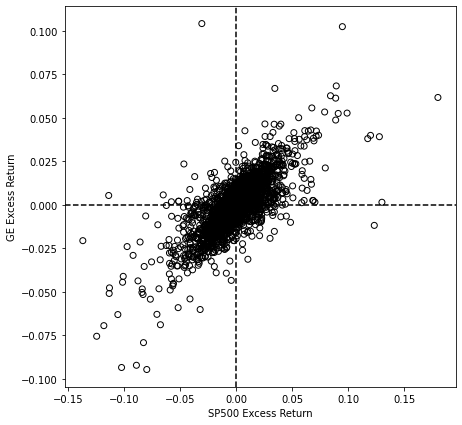

In [157]:
# plot the excess return of GE vs those of the SP500
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.scatter(daily_core_clean['geexcess'], daily_core_clean['sp500excess'],
             color='k', facecolors='none')
axes.axhline(y=0, color='k', linestyle='dashed')
axes.axvline(x=0, color='k', linestyle='dashed')
axes.set_xlabel("SP500 Excess Return")
axes.set_ylabel("GE Excess Return")

In [160]:
# fit regression
# prepare the data
x_sp500excess = daily_core_clean['sp500excess'].values.reshape((-1, 1))
y_geexcess = daily_core_clean['geexcess'].values.reshape((-1, 1))
x_sp500excess

array([[ 0.00176924],
       [ 0.00080496],
       [ 0.02658052],
       ...,
       [-0.00707433],
       [ 0.00366251],
       [-0.01441169]])

In [162]:
# fit the regression
capm_reg = LinearRegression().fit(x_sp500excess, y_geexcess)
capm_reg.coef_

array([[1.18913553]])

In [166]:
# use statsmodels 
# sp500_exog = sm.add_constant(x_sp500excess, prepend=False), add constant after main variables
sp500_exog = sm.add_constant(x_sp500excess)
sp500_exog

array([[ 1.00000000e+00,  1.76923827e-03],
       [ 1.00000000e+00,  8.04955253e-04],
       [ 1.00000000e+00,  2.65805165e-02],
       ...,
       [ 1.00000000e+00, -7.07432513e-03],
       [ 1.00000000e+00,  3.66251400e-03],
       [ 1.00000000e+00, -1.44116880e-02]])

In [168]:
capm_mod = sm.OLS(y_geexcess, sp500_exog)
capm_res = capm_mod.fit()
capm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     4394.
Date:                Sat, 27 Mar 2021   Prob (F-statistic):               0.00
Time:                        12:05:31   Log-Likelihood:                 9527.3
No. Observations:                3334   AIC:                        -1.905e+04
Df Residuals:                    3332   BIC:                        -1.904e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.563      0.573      -0.001       0.000
x1             1.1891      0.018     66.287      0.000       1.154       1.224
==============================================================================
Omnibus:                      771.899   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39742.427
Skew:                          -0.063   Prob(JB):                         0.00
Kurtosis:                      19.914   Cond. No.                         74.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that the t-statistic for the intercept is not significant.

In [178]:
# normality test
test_name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
norm_test = sms.jarque_bera(capm_res.resid)
list(zip(test_name, norm_test))

[('Jarque-Bera', 39742.42699230995),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', -0.06297411044089724),
 ('Kurtosis', 19.91367475562155)]

We have to reject the normality hypothesis. 

In [179]:
from statsmodels.compat import lzip
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(capm_res.resid)
lzip(name, test)

[('Chi^2', 771.8986664629913),
 ('Two-tail probability', 2.422893268400312e-168)]

In [181]:
# influence test
from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(capm_res)
test_class.dfbetas

array([[-0.00480982, -0.00064814],
       [ 0.01534898,  0.00096558],
       [ 0.00799512,  0.01577507],
       ...,
       [ 0.01274759, -0.00669606],
       [-0.00737874, -0.00203453],
       [ 0.00663412, -0.00713056]])

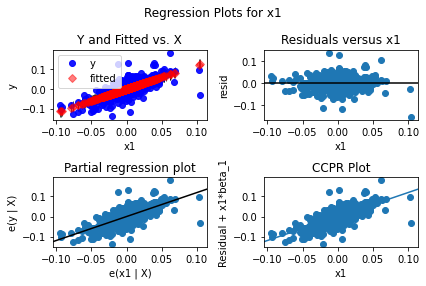

In [190]:
# diagnostic plot
fig = sm.graphics.plot_regress_exog(capm_res, 'x1')
fig.tight_layout(pad=1.0)

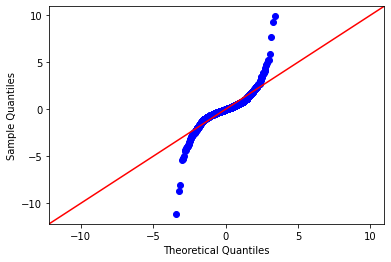

In [193]:
fig = sm.qqplot(capm_res.resid, fit=True, line="45")

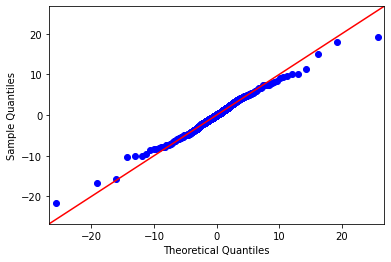

In [196]:
import scipy.stats as stats
fig = sm.qqplot(capm_res.resid, stats.t, fit=True, line="45")

### Adding Marco-economic Factors to CAPM

The CAPM relates a stock’s return to that of the diversified market portfolio, proxied here by the S&P 500 Index. A stock’s return can depend on macro-economic factors, such commodity prices, interest rates, economic growth (GDP).

In [208]:
daily_core_clean.head()

,ge,sp500,riskfree,geexcess,sp500excess,oilreturn
2000-01-05,-0.001737,0.001920,0.000151,-0.001888,0.001769,-0.036252
2000-01-06,0.013281,0.000955,0.000150,0.013130,0.000805,0.005663
2000-01-07,0.037991,0.026730,0.000149,0.037841,0.026581,0.000000
2000-01-10,-0.000414,0.011128,0.000452,-0.000865,0.010676,-0.003232
2000-01-11,0.001652,-0.013149,0.000151,0.001501,-0.013299,0.038894


In [209]:
import statsmodels.formula.api as smf
macro_model = smf.ols('geexcess ~ sp500excess + oilreturn', data=daily_core_clean).fit()
macro_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               geexcess   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     2208.
Date:                Sat, 27 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:10:35   Log-Likelihood:                 9532.5
No. Observations:                3334   AIC:                        -1.906e+04
Df Residuals:                    3331   BIC:                        -1.904e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0001      0.000     -0.513      0.608      -0.001       0.000
sp500excess     1.2003      0.018     65.773      0.000       1.165       1.236
oilreturn      -0.0311      0.010     -3.210      0.001      -0.050      -0.012
==============================================================================
Omnibus:                      768.427   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38146.394
Skew:                          -0.102   Prob(JB):                         0.00
Kurtosis:                      19.570   Cond. No.                         76.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression coefficient for the oil factor is statistically significant and negative. Over the analysis period, price changes in GE stock are negativel related to the price change in oil. 

In [210]:
sms.jarque_bera(macro_model.resid)

(38146.39394921012, 0.0, -0.10189429500654908, 19.569779323261102)

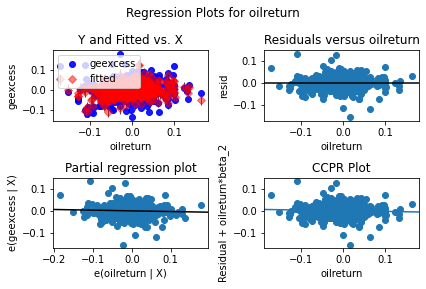

In [211]:
fig = sm.graphics.plot_regress_exog(macro_model, 'oilreturn')
fig.tight_layout(pad=1.0)

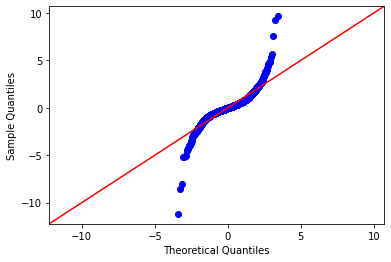

In [212]:
fig = sm.qqplot(macro_model.resid, fit=True, line="45")

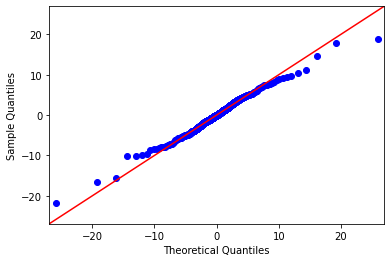

In [213]:
fig = sm.qqplot(macro_model.resid, stats.t, fit=True, line="45")

**It's better to fit the financial models with student-t distribution**

### References:

* [Yield Curve Explained](https://research.stlouisfed.org/publications/economic-synopses/2018/11/30/does-the-yield-curve-really-forecast-recession/?&utm_source=fred.stlouisfed.org&utm_medium=referral&utm_term=related_resources&utm_content=&utm_campaign=es)
* [Analyzing the new most-popular series in FRED](https://fredblog.stlouisfed.org/2018/08/whats-up-or-down-with-the-yield-curve/?utm_source=series_page&utm_medium=related_content&utm_term=related_resources&utm_campaign=fredblog)